# Wetland water depth visualisation <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic

%load_ext autoreload
%autoreload 2

## Load in our pre-analysed dataset

In [2]:
AllDataCombined = xr.open_dataset('AllDataCombined.nc')

In [3]:
AllDataCombined

<xarray.Dataset>
Dimensions:        (time: 1264, x: 483, y: 696)
Coordinates:
  * x              (x) float64 1.458e+06 1.458e+06 ... 1.47e+06 1.47e+06
  * y              (y) float64 -3.452e+06 -3.452e+06 ... -3.47e+06 -3.47e+06
  * time           (time) datetime64[ns] 1987-05-27T23:25:36.184280 ... 2019-08-15T23:49:02.469301952
Data variables:
    nbart_red      (time, y, x) float32 ...
    nbart_blue     (time, y, x) float32 ...
    nbart_green    (time, y, x) float32 ...
    nbart_nir      (time, y, x) float32 ...
    nbart_swir_1   (time, y, x) float32 ...
    nbart_swir_2   (time, y, x) float32 ...
    TCW            (time, y, x) float32 ...
    wet            (time, y, x) float32 ...
    justwetHAND    (y, x, time) float64 ...
    wetCount       (time, y, x) bool ...
    veg_randomUID  (y, x) float64 ...
    HAND           (y, x) float64 ...
    DEM            (y, x) float32 ...
    DEMCorr        (y, x) float64 ...
    DEMDir         (y, x) float64 ...
    DEMAcc         (y, x) float64 ...
Attributes:
    crs:      +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0 +y_0...

We also need to load in the species dictionary we saved out

In [4]:
with open('SpeciesDict.txt', 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

We also need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [5]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [6]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    XTickNames.append(VegName)

## And start playing with it

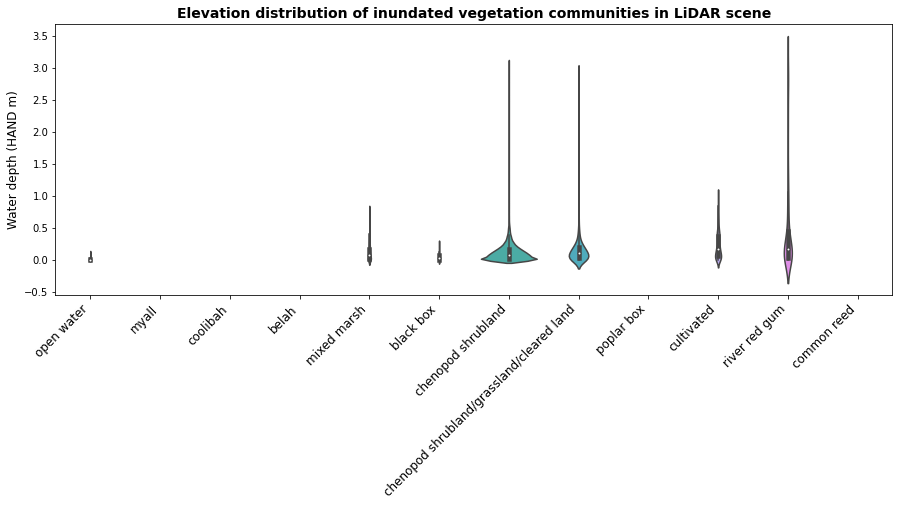

In [7]:
fig = plt.figure(figsize=[15,5])
ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                    y=AllDataCombined['justwetHAND'].isel(time=30).values.flatten(), 
                    order=myorder, scale='count')
ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
plt.ylabel('Water depth (HAND m)', fontsize = 12);
plt.title('Elevation distribution of inundated vegetation communities in LiDAR scene', fontsize = 14, fontweight = 'bold');

### Count the number of wet observations for each pixel, and plot against HAND

We would hope that the higher pixels are inundated less frequently...

In [8]:
AllDataCombined['WetFreq'] = AllDataCombined.wet.count(dim='time')

## Calculate wet count per scene curves

Count up the number of wet pixels in each timestep

In [9]:
WetCountPerTime = AllDataCombined.wetCount.sum(dim=['x', 'y'])
# Remove any observations where everything is dry
WetCountPerTime = WetCountPerTime[WetCountPerTime != 0]

In [10]:
AllDataCombined['WetCounts'] = WetCountPerTime

Sort this from highest to lowest, and assign a cumulative percent axis to plot against

In [11]:
# Sort highest to lowest
WetCountPerTimeSorted = -np.sort(-WetCountPerTime.values)
# Create an array the length of the total number of observations
CumulativePct = np.array(range(len(WetCountPerTime.values)))
# Turn that array into a percent
CumulativePct = (CumulativePct / len(CumulativePct)) * 100

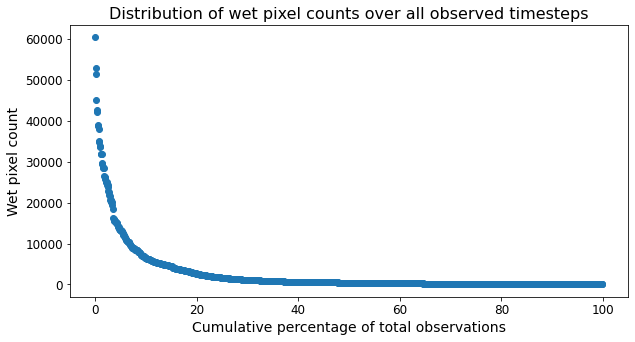

In [12]:
fig, ax = plt.subplots(figsize=[10,5]);
plt.plot(CumulativePct, WetCountPerTimeSorted, 'o');
ax.tick_params(axis = 'both', labelsize = 12)
plt.xlabel('Cumulative percentage of total observations', fontsize=14);
plt.ylabel('Wet pixel count', fontsize=14);
plt.title('Distribution of wet pixel counts over all observed timesteps', fontsize=16);

### Create the same curves by decade

In [13]:
Decades = {'1990s':('1990-01-01', '1999-12-31'), '2000s':('2000-01-01', '2009-12-31'), '2010s':('2010-01-01', '2019-12-31')}

DecadeData = {}
for name, decade in Decades.items():
    WetCount = WetCountPerTime.sel({'time': slice(*decade)})
    SortedCount = -np.sort(-WetCount.values)
    CumPct = np.array(range(len(SortedCount)))
    CumPct = (CumPct / len(CumPct)) * 100
    DecadeData.update({name: list(zip(CumPct, SortedCount))})

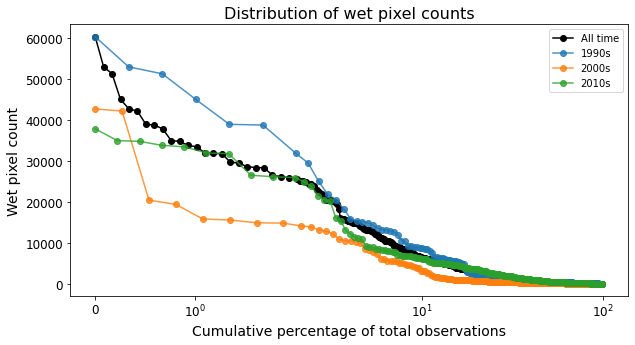

In [14]:
fig, ax = plt.subplots(figsize=[10,5]);
plt.plot(CumulativePct, WetCountPerTimeSorted, 'o-k', label='All time');
for names, data in DecadeData.items():
    CumPct, SortedCount = list(zip(*data))
    plt.plot(CumPct, SortedCount, 'o-', alpha=0.8, label=names);
# apply a symlog scale (symmetrical log) to highlight values near zero
plt.xscale('symlog')
ax.tick_params(axis = 'both', labelsize = 12)
plt.legend()
plt.xlabel('Cumulative percentage of total observations', fontsize=14);
plt.ylabel('Wet pixel count', fontsize=14);
plt.title('Distribution of wet pixel counts', fontsize=16);

## Draw violin plots according to wet pixel count

Now that we have wet pixel counts for each scene, we can draw violin plots showing the inundation of vegetation types for different wetness counts

In [63]:
AllDataCombined['HANDclip'] = AllDataCombined['justwetHAND'].where(AllDataCombined['HAND']<=2)

In [71]:
WetCountPercentiles = np.percentile(WetCountPerTime.values, [1, 5, 10, 25, 50, 75, 99], interpolation='nearest')

In [72]:
PercentilesLoop = dict(list(zip(['1', '5', '10', '25', '50', '75', '99'], WetCountPercentiles)))
PercentilesData = {}

for pctname, perctl in PercentilesLoop.items():
    FindTime = AllDataCombined.time.where(AllDataCombined['WetCounts'] == perctl, drop=True)
    PercentilesData.update({pctname: {'percentile': perctl, 'timestep':FindTime}})

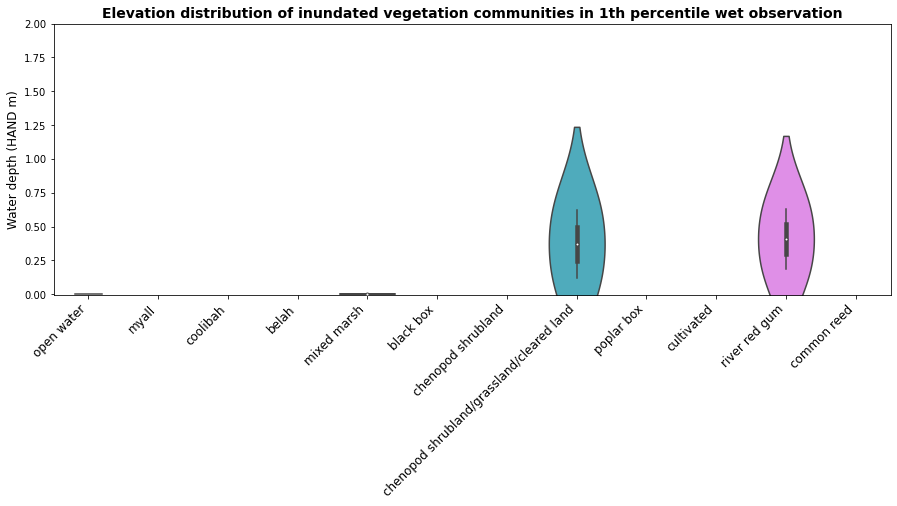

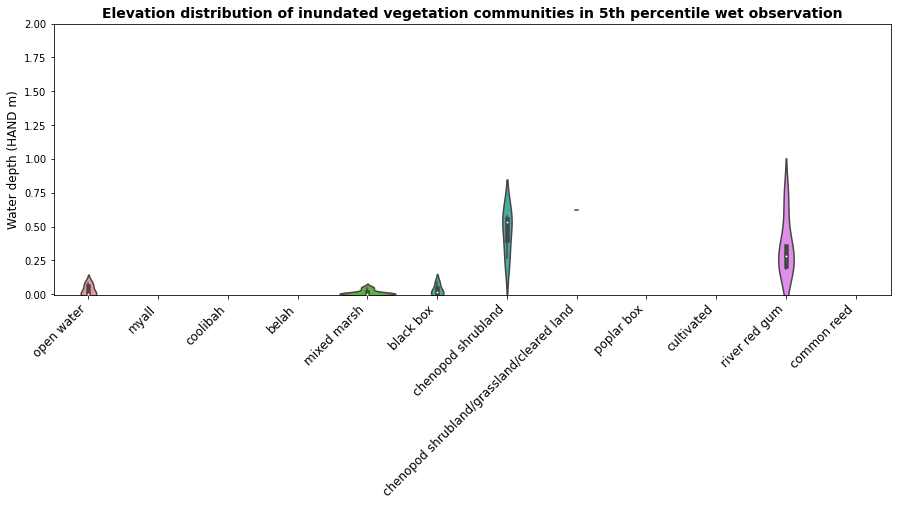

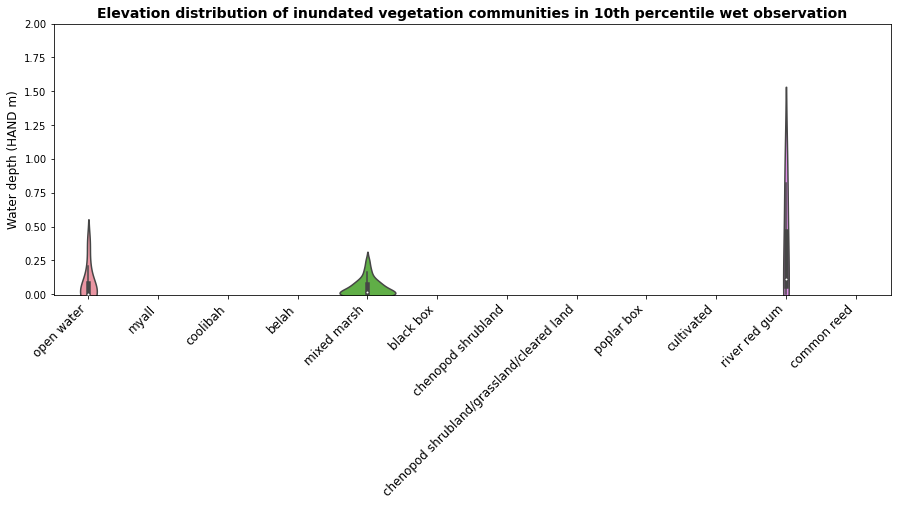

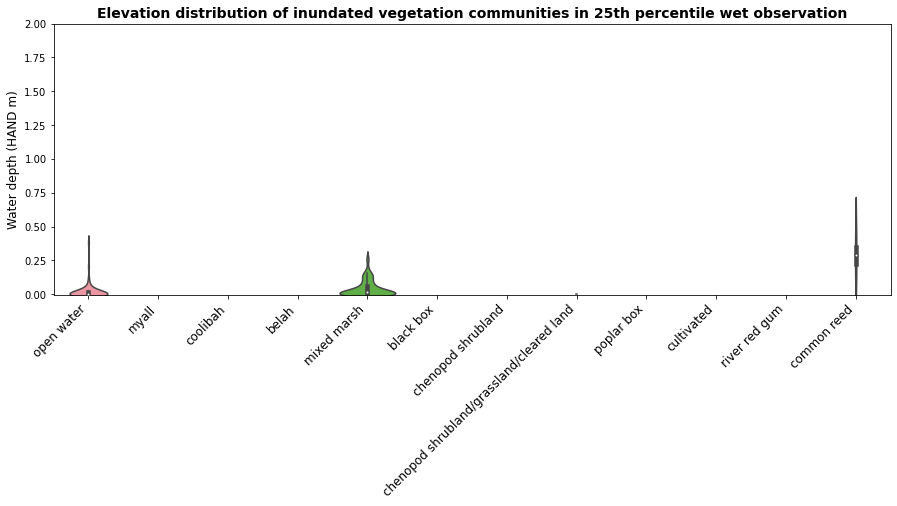

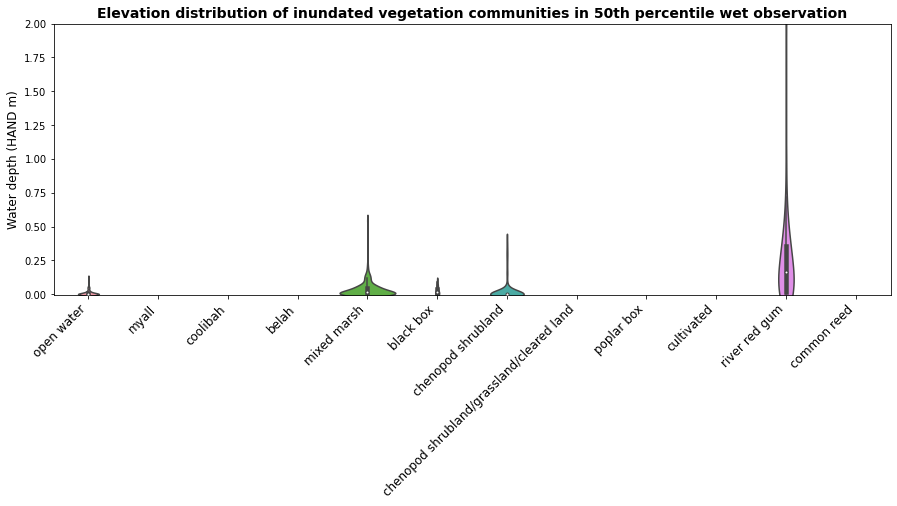

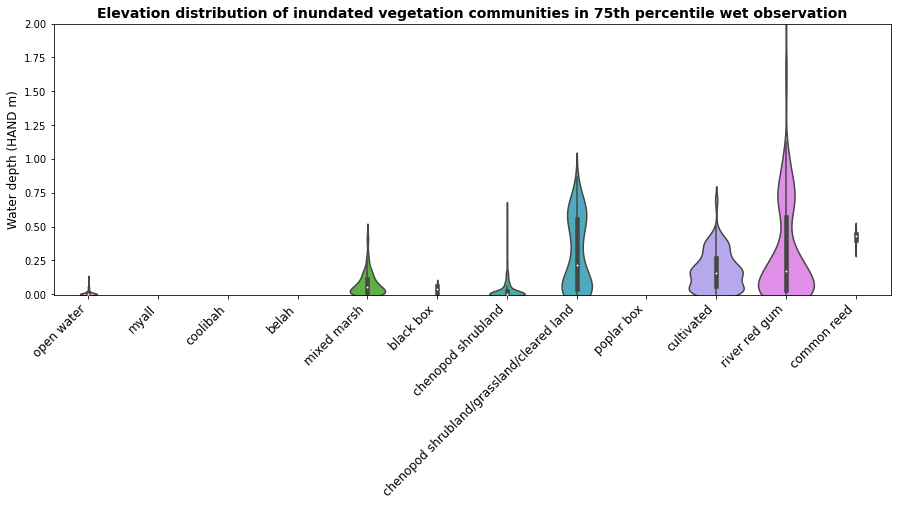

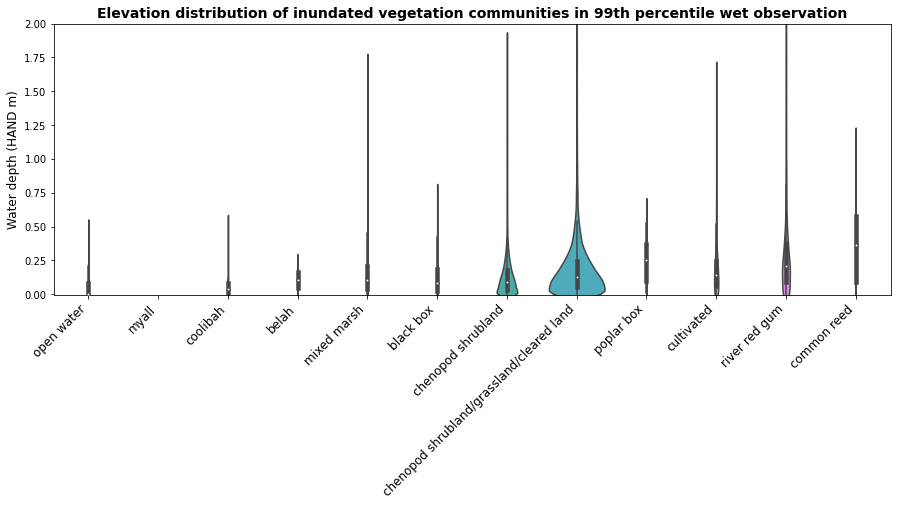

In [75]:
for perctl, pctdata in PercentilesData.items():
    fig = plt.figure(figsize=[15,5])
    if len(AllDataCombined['HANDclip'].sel(time=pctdata['timestep']).time) != 1:
        yvalues = AllDataCombined['HANDclip'].sel(time=pctdata['timestep']).mean(dim='time')
    else:
        yvalues = AllDataCombined['HANDclip'].sel(time=pctdata['timestep'])
    ax = sns.violinplot(x=AllDataCombined['veg_randomUID'].values.flatten(), 
                        y=yvalues.values.flatten(), 
                        order=myorder, scale='count')
    ax.set_xticklabels(XTickNames, rotation=45, ha='right', fontsize=12);
    ax.set(ylim=(-0.01, 2))
    plt.ylabel('Water depth (HAND m)', fontsize = 12);
    plt.title(f'Elevation distribution of inundated vegetation communities in {perctl}th percentile wet observation', 
              fontsize = 14, fontweight = 'bold');